**Imports**

In [101]:
using FFTW, Plots
using DSP: unwrap, conv

**Constants / Material & Signal parameters**

In [219]:
# CONSTANTS
c = 299792458

# WAVEGUIDE
fr = 0.18
τl = 32e-15
τvib = 12.2e-15
L = 0.5
α = 0.0
γ = 0.11
λc = 835e-9
ω0 = 2π*c/λc
βs = [0.0, -1.1830e-026]

# SIGNAL 
T = 12.5e-12 # Duration
N = 2^14 # Time samples
τ = 0.05e-12/ (2log(1+sqrt(2)))
P = abs(βs[2]/(γ*τ^2))
n = 3
# VECTORS 
dt = T/N
t = T*(-N÷2:N÷2-1)/N;
ν = fftshift((-N÷2:N÷2-1)./T);
ω = 2π.*ν;

u0 = n*sqrt(P)*sech.(t ./ τ);

**Simulation parameters**

In [237]:
# SIMULATION 

nsaves = 256
dz = L/(2*nsaves) 
reltol = 1e-6
maxiters = 1000

u = ComplexF64.(u0)
FFT = plan_fft(u)
IFFT = plan_ifft(u)
zsaves = (0:nsaves)*L/nsaves

M = zeros(ComplexF64, (nsaves+1, N))

hr = ( τvib^2 +  τl^2) / τvib / τl^2 * exp.(-t / τl) .* sin.(t / τvib)
hr[t.<=0] .= 0.0
RW = (FFT * reverse(hr))

# Messed up with reverse and fft-shift
# Need to manage to find faster calculation (avoid fftshift ?) using conjugate ?


NL1(u) = 1.0im .* γ * FFT * (u .* abs2.(u))

function NL2(u)
	return 1.0im .* γ * (1 .+ ω/ω0) .*  (FFT * (u .* abs2.(u)))
end


# contruct NL function with meta programming (GNLSE can be reduce to NLSE w and w/ self steepening)
function NL3(u)
	
	η = 1 .+ ω/ω0
	IT = abs2.(u)
	RS = dt*fr*ifftshift(IFFT * ((FFT * IT) .* RW))
	M = FFT * ( u .* ((1.0-fr).*IT .+ RS))
	return 1.0im .* γ * η .* M
end


function _compute_error(a, b)
	sqrt(sum(abs2.(a .- b)) ./ sum(abs2.(a)))
end

NL = NL3

U = FFT*u
NU = NL(u)
D = -0.5α .+ 1im*sum([ (βs[i]/factorial(i)) .*ω.^i for i in eachindex(βs) ]);

M[1,:] = U
ϵ_hist = []
zk = 0
k5 = nothing
for i in 2:nsaves+1
it = 0
while zk < zsaves[i]

	e = exp.(0.5 * dz * D)

	Uip = e .* U

	k1 = e .* NU

	k2 = NL(IFFT*(Uip .+ 0.5 * dz * k1))

	k3 = NL(IFFT*(Uip .+ 0.5 * dz * k2))

	k4 = NL(IFFT*(e .* (Uip .+ dz * k3)))

	r = e .* (Uip .+ dz * (k1 / 6.0 .+ k2 / 3.0 .+ k3 / 3.0))

	U1 = r .+ dz * k4 / 6.0

	k5 = NL(IFFT*U1)

	U2 = r .+ dz * (k4 / 15.0 .+ k5 / 10.0)

	err = _compute_error(U1, U2)
	
	dzopt = max(0.5, min(2.0, 0.9 * sqrt(sqrt(reltol / err)))) * dz

	if err <= reltol

		dz = min(dzopt, abs(zsaves[i] - zk))
		zk = zk + dz
		append!(ϵ_hist, err)
		U = U1
		NU = k5
	else
		dz = dzopt
		it = it + 1
		if (it >= maxiters)
			throw(ErrorException("Max number of iteration exceeded!"))
		end
	end
end
M[i,:] = U

end

SOL = ifft(M,2);

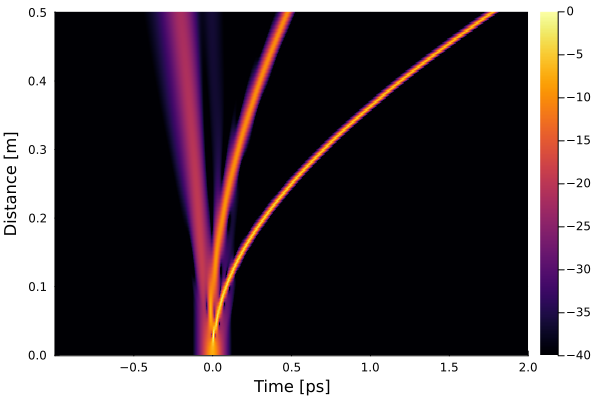

In [238]:
TT =  -1e-12 .<= t .<= 2e-12
SOLr = reverse(SOL, dims=2)[:,TT] .|> abs2 
SOLr = SOLr ./ maximum(SOLr)
MIT = 10log10.(SOLr)

heatmap(t[TT]*1e12, zsaves, MIT, clims=(-40,0))
xlabel!("Time [ps]")
ylabel!("Distance [m]")



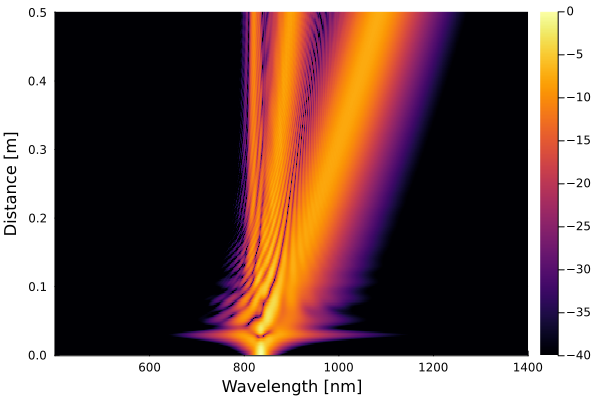

In [239]:
V =  (fftshift(reverse(ω)) .+ ω0)
WL = (2pi*c ./ V * 1e9)
widx = 400 .<= WL .<= 1400
WSOLr = reverse(ifftshift(M,2), dims=2)[:,widx] .|> abs2 
WSOLr = WSOLr ./ maximum(WSOLr)
MIW = 10log10.(WSOLr)

heatmap(WL[widx], zsaves, MIW, clims=(-40,0))
xlabel!("Wavelength [nm]")
ylabel!("Distance [m]")


**Able to reproduce perfectly the results from other packages**

Here we reproduced the 3rd order soliton simulations from the python module *gnlse*.

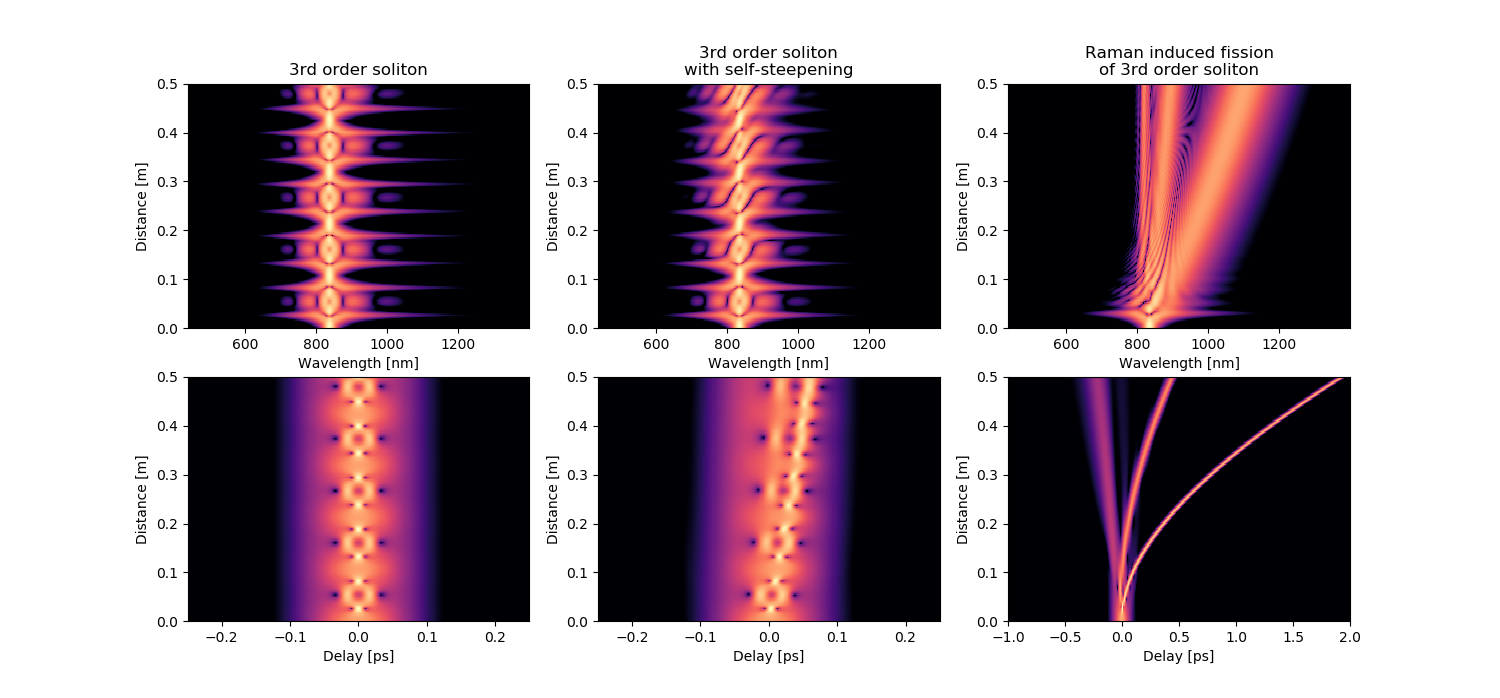